In [1]:
import numpy as np
import torch

import sys
import os
__file__ = os.path.abspath('')

import helpers

sys.path.append('..')


import epde
from epde.preprocessing.deriv_calculators import Heatmap

In [2]:
def get_wave_inputs():
    shape = 80
    
    print(os.path.dirname( __file__ ))
    data_file = os.path.join(os.path.dirname( __file__ ), f'examples/data/wave_sln_{shape}.csv')
    data = np.loadtxt(data_file, delimiter = ',').T
    t = np.linspace(0, 1, shape+1); x = np.linspace(0, 1, shape+1)
    grids = np.meshgrid(t, x, indexing = 'ij')
    return grids, data

In [3]:
grids, data = get_wave_inputs()

/home/maslyaev/epde/EPDE_main


In [4]:
train_max = 40
grids_training = (grids[0][:train_max, ...], grids[1][:train_max, ...])
grids_test = (grids[0][train_max:, ...], grids[1][train_max:, ...])

data_training, data_test = data[:train_max, ...], data[train_max:, ...]

In [5]:
grids_test[0].shape

(41, 81)

In [13]:
def epde_discovery(grids, data, derivs, use_ann = False, multiobjective_mode = True):
    dimensionality = data.ndim - 1
    
    epde_search_obj = epde.EpdeSearch(multiobjective_mode=multiobjective_mode, use_solver = False, 
                                          dimensionality = dimensionality, boundary = 15,
                                          coordinate_tensors = grids)    

    popsize = 12
    if multiobjective_mode:
        epde_search_obj.set_moeadd_params(population_size = popsize, 
                                          training_epochs=40)
    else:
        epde_search_obj.set_singleobjective_params(population_size = popsize, 
                                                   training_epochs=100)
    
    custom_grid_tokens = epde.CacheStoredTokens(token_type = 'grid',
                                                token_labels = ['t', 'x'],
                                                token_tensors={'t' : grids[0], 'x' : grids[1]},
                                                params_ranges = {'power' : (1, 1)},
                                                params_equality_ranges = None)        
    trig_tokens = epde.TrigonometricTokens(dimensionality = dimensionality)
    
    factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.8, 0.2]}
    
    opt_val = 5e-1
    bounds = (1e-8, 1e0) if multiobjective_mode else (opt_val, opt_val)    
    epde_search_obj.fit(data=data, variable_names=['u',], max_deriv_order=(2, 2), derivs = derivs,
                        equation_terms_max_number=5, data_fun_pow = 1, additional_tokens=[trig_tokens, custom_grid_tokens], 
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=bounds)

    return epde_search_obj

In [7]:
epde_search_obj = epde_discovery(grids_training, data_training, derivs = None,
                                 multiobjective_mode = False)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f9939643700>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f9939643a30>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f9939643a30>
trig_token_params: VALUES = (0, 1)
Deriv orders after definition [[0], [0, 0], [1], [1, 1]]
3240
initial_shape (40, 81) derivs_tensor.shape (3240, 4)
self.tokens is ['du/dx0', 'd^2u/dx0^2', 'du/dx1', 'd^2u/dx1^2']
Here, derivs order is {'du/dx0': [0], 'd^2u/dx0^2': [0, 0], 'du/dx1': [1], 'd^2u/dx1^2': [1, 1]}
self.tokens is ['u']
Here, derivs order is {'u': [None]}
The cardinality of defined token pool is [1 4 2 2]
Among them, the pool contains [1 4]
self.vars_demand_equation {'u'}
Creating new equation, sparsity value 0.5
New solution accepted, confirmed 1/12 solutions.
Creating new equation, sparsity value 0.5
New solution accepted, confirmed 2/12 solutions.
Creating new equation, sparsity value 0.5
New solution accepted, co

In [9]:
epde_search_obj.equations()

0.0 * d^2u/dx1^2{power: 1.0} + 0.0 * du/dx1{power: 1.0} + 0.16519854976113846 * du/dx0{power: 1.0} * u{power: 1.0} + 0.0 * u{power: 1.0} + 0.008197456689165775 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 3.3975603441103734, dim: 1.0}
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': False, 'value': 0.5}} , with objective function values of [0.3258079] 



In [12]:
ders = epde_search_obj.saved_derivaties
ders['u'].shape

(3240, 4)

In [14]:
epde_search_obj = epde_discovery(grids_training, data_training, derivs = [ders['u']],
                                 multiobjective_mode = True)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f99d45be1f0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f99d45be1f0>
trig_token_params: VALUES = (0, 1)
Deriv orders after definition [[0], [0, 0], [1], [1, 1]]
initial_shape (40, 81) derivs_tensor.shape (3240, 4)
self.tokens is ['du/dx0', 'd^2u/dx0^2', 'du/dx1', 'd^2u/dx1^2']
Here, derivs order is {'du/dx0': [0], 'd^2u/dx0^2': [0, 0], 'du/dx1': [1], 'd^2u/dx1^2': [1, 1]}
self.tokens is ['u']
Here, derivs order is {'u': [None]}
The cardinality of defined token pool is [1 4 2 2]
Among them, the pool contains [1 4]
self.vars_demand_equation {'u'}
Creating new equation, sparsity value [7.25747715e-07]
New solution accepted, confirmed 1/12 solutions.
Creating new equation, sparsity value [0.00311425]
New solution accepted, confirmed 2/12 solutions.
Creating new equation, sparsity value [0.21688241]
New solution accepted, confirmed 3/12 solutions.
Creating new equation, sparsity value 

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 14-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 15-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO 

During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 31-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 32-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO 

In [10]:
epde_search_obj.equations()



0-th non-dominated level


-0.5496878845172918 * u{power: 1.0} * t{power: 1.0} + -0.05112489217014476 * u{power: 1.0} + 0.0 * du/dx1{power: 1.0} * x{power: 1.0} + 0.0 * du/dx1{power: 1.0} + 0.7892463027250493 = du/dx0{power: 1.0}
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0020510539676752717}} , with objective function values of [0.64180359 2.5       ] 

0.0 * d^2u/dx0^2{power: 1.0} * du/dx1{power: 1.0} + 0.039994341975063886 * d^2u/dx1^2{power: 1.0} + 0.0 * du/dx1{power: 1.0} + 0.0 * u{power: 1.0} * du/dx1{power: 1.0} + -0.02059504177543492 = d^2u/dx0^2{power: 1.0}
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0005922902356125623}} , with objective function valu

$\begin{eqnarray*} \frac{\partial u}{\partial x_0} = -5.497\cdot 10^{-1} u \cdot t{power: 1.0} + -5.112\cdot 10^{-2} u + 7.892\cdot 10^{-1}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = 3.999\cdot 10^{-2} \frac{\partial ^2u}{\partial x_1^2} + -2.06\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} = -1.845\cdot 10^{-1} u + 7.864\cdot 10^{-1}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = 3.987\cdot 10^{-2} \frac{\partial ^2u}{\partial x_1^2} + -3.791\cdot 10^{-3} u + -9.668\cdot 10^{-3}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot t{power: 1.0} = 3.171\cdot 10^{-1} \frac{\partial u}{\partial x_0} + 1.209\cdot 10^{-2} u + -5.369\cdot 10^{-2}  \end{eqnarray*}$


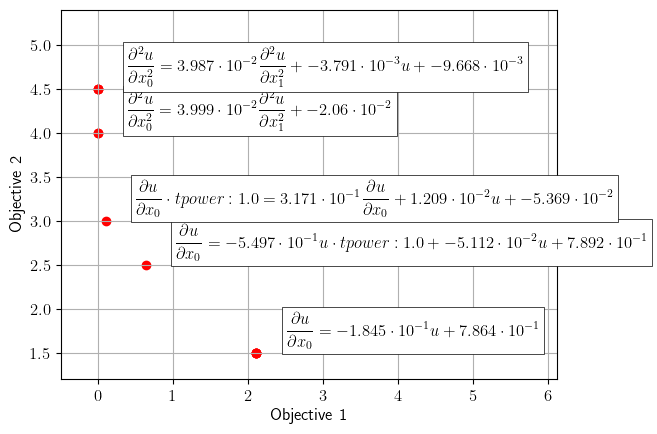

In [11]:
epde_search_obj.visualize_solutions()

In [13]:
systems = {'2' : epde_search_obj.get_equations_by_complexity(2)[0],
           '4' : epde_search_obj.get_equations_by_complexity(4)[0]}

In [14]:
t, x = np.unique(grids[0]), np.unique(grids[1])

In [15]:
epde_search_obj.saved_derivaties

{'u': array([[ 0.00000000e+00,  0.00000000e+00,  1.21893604e+00,
          1.99658704e+02],
        [ 3.14429868e-02,  2.54933046e+00,  3.53417339e+00,
          1.84844299e+02],
        [ 5.05541513e-02,  3.80805166e+00,  5.66891429e+00,
          1.70404493e+02],
        ...,
        [ 5.17249081e-01, -3.63689548e+00, -1.37043347e+01,
         -1.09763264e+02],
        [ 1.80894000e-01, -2.60133166e+00, -1.50330578e+01,
         -1.25877305e+02],
        [-0.00000000e+00,  0.00000000e+00, -1.65452194e+01,
         -1.35648004e+02]])}

In [16]:
from epde.interface.solver_integration import BoundaryConditions, BOPElement

bnd_t = torch.cartesian_prod(torch.from_numpy(np.array([t[train_max + 1]], dtype=np.float64)),
                             torch.from_numpy(x)).float()

bop_1 = BOPElement(axis = 0, key = 'u_t', term = [None], power = 1, var = 0)
bop_1.set_grid(bnd_t)
bop_1.values = torch.from_numpy(data_test[0, ...]).float()
print('bop 1:', bop_1.values.shape)

t_der = epde_search_obj.saved_derivaties['u'][..., 0].reshape(grids_training[0].shape)
bop_2 = BOPElement(axis = 0, key = 'dudt', term = [0], power = 1, var = 0)
bop_2.set_grid(bnd_t)
bop_2.values = torch.from_numpy(t_der[-1, ...]).float()
print('bop 2:', bop_2.values.shape)

bnd_x1 = torch.cartesian_prod(torch.from_numpy(t[train_max:]),
                              torch.from_numpy(np.array([x[0]], dtype=np.float64))).float()
bnd_x2 = torch.cartesian_prod(torch.from_numpy(t[train_max:]),
                              torch.from_numpy(np.array([x[-1]], dtype=np.float64))).float()            

bop_3 = BOPElement(axis = 1, key = 'u_x1', term = [None], power = 1, var = 0)
bop_3.set_grid(bnd_x1)
bop_3.values = torch.from_numpy(data_test[..., 0]).float()
print('bop 3:', bop_3.values.shape)

bop_4 = BOPElement(axis = 1, key = 'u_x2', term = [None], power = 1, var = 0)
bop_4.set_grid(bnd_x2)
bop_4.values = torch.from_numpy(data_test[..., -1]).float()
print('bop 4:', bop_4.values.shape)

bop 1: torch.Size([81])
bop 2: torch.Size([81])
bop 3: torch.Size([41])
bop 4: torch.Size([41])


In [17]:
systems['4'].text_form

"0.039994341975063886 * d^2u/dx1^2{power: 1.0} + 0.0 * du/dx1{power: 1.0} + 0.0 * d^2u/dx1^2{power: 1.0} * du/dx1{power: 1.0} + 0.0 * u{power: 1.0} * du/dx1{power: 1.0} + -0.02059504177543492 = d^2u/dx0^2{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.03388273808409926}}"

In [18]:
grids_test[0].shape

(41, 81)

In [19]:
from epde.interface.solver_integration import SystemSolverInterface

ss_interface = SystemSolverInterface(system_to_adapt=systems['4'])
form = ss_interface.form(grids = grids_test)

target_form shape is torch.Size([3321, 1])


In [20]:
form[0][1].keys()

dict_keys(['d^2u/dx1^2{power: 1.0}', 'C', 'd^2u/dx0^2{power: 1.0}'])

In [21]:
form[0][1]['d^2u/dx0^2{power: 1.0}']

{'coeff': tensor([[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]),
 'term': [0, 0],
 'pow': 1.0,
 'var': [0]}

In [22]:
pred_u_v_4 = epde_search_obj.predict(system=systems['4'], mode='mat', 
                                     boundary_conditions=[bop_1(), bop_2(), bop_3(), bop_4()],
                                     grid = grids_test)

Using explicitly sent system of equations.
dimensionality is 2
grid.shape is (41, 81)
In grid format prepare: grid shape is torch.Size([2, 41, 81])
Shape of the grid for solver torch.Size([2, 41, 81])
target_form shape is torch.Size([41, 81])
In grid format prepare: grid shape is torch.Size([2, 41, 81])
Grid is  <class 'torch.Tensor'> torch.Size([2, 41, 81])
torch.Size([41, 81])
before Model_prepare: torch.float64
after Model_prepare: torch.float64
[2024-02-01 13:55:31.058434] initial (min) loss is 389.6265869140625
[2024-02-01 13:55:31.245747] Print every 5000 step
Step = 0 loss = 389.626587 normalized loss line= -0.000000x+1.000000. There was 1 stop dings already.
[2024-02-01 13:55:34.843923] No improvement in 100 steps
Step = 139 loss = 363.974487 normalized loss line= 0.000014x+0.985185. There was 1 stop dings already.
[2024-02-01 13:56:38.009521] Print every 5000 step
Step = 5000 loss = 254.840408 normalized loss line= -0.000070x+1.014118. There was 2 stop dings already.
[2024-02-

In [25]:
pred_u_v_4.shape

(3321, 1)

In [ ]:
pred_u_v_4 = epde_search_obj.predict(system=systems['4'], boundary_conditions=[bop_1(), bop_2(), bop_3(), bop_4()], 
                                     grid = grids_test, mode='autograd')

In [26]:
pred_u_v_4_sh = pred_u_v_4.reshape(grids_test[0].shape)

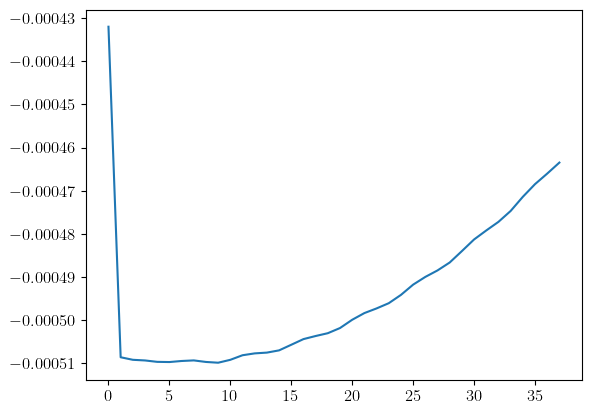

In [27]:
import matplotlib.pyplot as plt
plt.plot(data_training[:-2, 30] - 2*data_training[1:-1, 30] + data_training[2:, 30])
plt.show()

In [37]:
print(data_test.shape, pred_u_v_4_sh.shape)
print(np.mean(np.abs((data_test - pred_u_v_4_sh))))

(41, 81) (41, 81)
0.02205541645507997


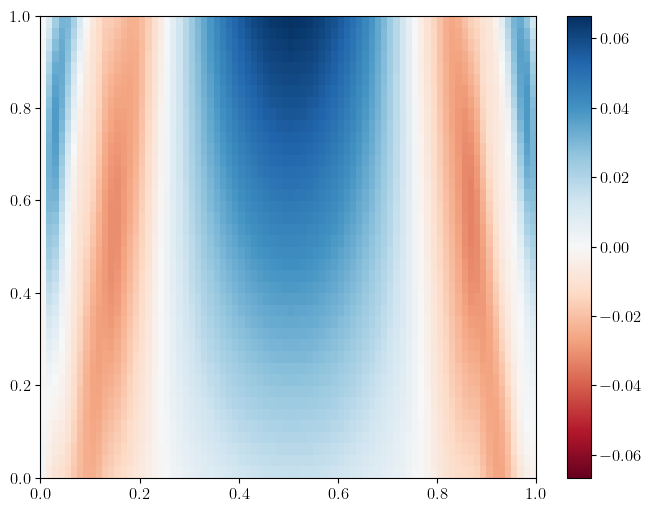

In [33]:
Heatmap(pred_u_v_4_sh - data_test)

In [24]:
grids[0]

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125],
       [0.025 , 0.025 , 0.025 , ..., 0.025 , 0.025 , 0.025 ],
       ...,
       [0.975 , 0.975 , 0.975 , ..., 0.975 , 0.975 , 0.975 ],
       [0.9875, 0.9875, 0.9875, ..., 0.9875, 0.9875, 0.9875],
       [1.    , 1.    , 1.    , ..., 1.    , 1.    , 1.    ]])

In [25]:
pred_u_v_4.reshape(grids[0].shape)

ValueError: cannot reshape array of size 3240 into shape (81,81)

In [ ]:
from epde.interface.solver_integration import BoundaryConditions, SolverAdapter, SystemSolverInterface

In [ ]:
adapter = SolverAdapter(var_number = len(systems['4'].vars_to_describe))

In [ ]:
ssi = SystemSolverInterface(systems['4'])

In [ ]:
ssi.form()

In [82]:
import epde.globals as global_var

In [84]:
global_var.grid_cache.get_all()[1]

[array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125],
        [0.025 , 0.025 , 0.025 , ..., 0.025 , 0.025 , 0.025 ],
        ...,
        [0.4625, 0.4625, 0.4625, ..., 0.4625, 0.4625, 0.4625],
        [0.475 , 0.475 , 0.475 , ..., 0.475 , 0.475 , 0.475 ],
        [0.4875, 0.4875, 0.4875, ..., 0.4875, 0.4875, 0.4875]]),
 array([[0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        ...,
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ],
        [0.    , 0.0125, 0.025 , ..., 0.975 , 0.9875, 1.    ]])]

Solver testing

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time

import pandas as pd
from scipy.integrate import quad
import sys
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
sys.path.append('../')
sys.path.pop()
sys.path.append(os.path.abspath(os.path.join(os.path.dirname( __file__ ), '..')))

from epde.solver.input_preprocessing import Equation
from epde.solver.solver import Solver
from epde.solver.solution import Solution

In [34]:
def solver_burgers(grid_res, cache, optimizer, iterations):
    exp_dict_list = []
    start = time.time()
    mu = 0.01 / np.pi
    x = torch.from_numpy(np.linspace(-1, 1, grid_res + 1))
    t = torch.from_numpy(np.linspace(0, 1, grid_res + 1))
    h = (x[1] - x[0]).item()
    grid = torch.cartesian_prod(x, t).float()

    ##initial cond
    bnd1 = torch.cartesian_prod(x, torch.from_numpy(np.array([0], dtype=np.float64))).float()
    bndval1 = -torch.sin(np.pi * bnd1[:, 0])

    ##boundary cond
    bnd2 = torch.cartesian_prod(torch.from_numpy(np.array([-1.], dtype=np.float64)), t).float()
    bndval2 = torch.zeros_like(bnd2[:, 0])

    ##boundary cond
    bnd3 = torch.cartesian_prod(torch.from_numpy(np.array([1.], dtype=np.float64)), t).float()
    bndval3 = torch.zeros_like(bnd3[:, 0])

    bconds = [[bnd1, bndval1, 'dirichlet'],
              [bnd2, bndval2, 'dirichlet'],
              [bnd3, bndval3, 'dirichlet']]

    burgers_eq = {
        'du/dt**1':
            {
                'coeff': 1.,
                'du/dt': [1],
                'pow': 1,
                'var': 0
            },
        '+u*du/dx':
            {
                'coeff': 1,
                'u*du/dx': [[None], [0]],
                'pow': [1, 1],
                'var': [0, 0]
            },
        '-mu*d2u/dx2':
            {
                'coeff': -mu,
                'd2u/dx2': [0, 0],
                'pow': 1,
                'var': 0
            }
    }

    model = torch.nn.Sequential(
        torch.nn.Linear(2, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 1)
    )

    equation = Equation(grid, burgers_eq, bconds).set_mode('autograd')
    if type(optimizer) is list:
        for mode in optimizer:
            print(f'Grid shape is {grid.shape}')
            model = Solver(grid, equation, model, 'autograd').solve(lambda_bound=1, verbose=0, learning_rate=1e-3,
                                                                      eps=1e-6, tmin=10, tmax=iterations,
                                                                      use_cache=cache, cache_dir='../cache/',
                                                                      patience=2,
                                                                      save_always=cache, no_improvement_patience=100,
                                                                      optimizer_mode=mode)
    else:
        print(f'Grid shape is {grid.shape}')
        model = Solver(grid, equation, model, 'autograd').solve(lambda_bound=1, verbose=0, learning_rate=1e-3,
                                                                  eps=1e-6, tmin=10, tmax=iterations, use_cache=cache,
                                                                  cache_dir='../cache/', patience=2,
                                                                  save_always=cache, no_improvement_patience=100,
                                                                  optimizer_mode='Adam')
    end = time.time()
    time_part = end - start

    x1 = torch.from_numpy(np.linspace(-1, 1, grid_res + 1))
    t1 = torch.from_numpy(np.linspace(0, 1, grid_res + 1))
    grid1 = torch.cartesian_prod(x1, t1).float()

    u_exact = exact(grid1)
    error_rmse = torch.sqrt(torch.mean((u_exact - model(grid1)) ** 2))
    end_loss, _ = Solution(grid = grid, equal_cls = equation, model = model,
                        mode = 'autograd', weak_form=None, lambda_operator=1, lambda_bound=1).evaluate()
    exp_dict_list.append({'grid_res': grid_res, 'time': time_part, 'RMSE': error_rmse.detach().numpy(),
                          'loss': end_loss.detach().numpy(), 'type': 'solver_burgers', 'cache': cache})

    print('Time taken {}= {}'.format(grid_res, end - start))
    print('RMSE {}= {}'.format(grid_res, error_rmse))
    print('loss {}= {}'.format(grid_res, end_loss))

    return exp_dict_list

In [35]:
def exact(grid):
    mu = 0.01 / np.pi

    def f(y):
        return np.exp(-np.cos(np.pi * y) / (2 * np.pi * mu))

    def integrand1(m, x, t):
        return np.sin(np.pi * (x - m)) * f(x - m) * np.exp(-m ** 2 / (4 * mu * t))

    def integrand2(m, x, t):
        return f(x - m) * np.exp(-m ** 2 / (4 * mu * t))

    def u(x, t):
        if t == 0:
            return -np.sin(np.pi * x)
        else:
            return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[
                0]

    solution = []
    for point in grid:
        solution.append(u(point[0].item(), point[1].item()))

    return torch.tensor(solution)

solver_burgers(20, False, 'Adam', 2000)

Grid shape is torch.Size([441, 2])
before Model_prepare: torch.float32
after Model_prepare: torch.float32
Time taken 20= 11.31909990310669
RMSE 20= 0.7666455618134793
loss 20= tensor([0.0116], grad_fn=<AddBackward0>)


[{'grid_res': 20,
  'time': 11.31909990310669,
  'RMSE': array(0.76664556),
  'loss': array([0.01157083], dtype=float32),
  'type': 'solver_burgers',
  'cache': False}]